In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from PIL import ImageDraw
from random import randint
from torchvision.models import resnet34

In [3]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-96'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-256'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

In [4]:
path_img = path/'small-256'

In [5]:
size = 128 * 2
bs = 50

In [6]:
src = ImageImageList.from_folder(path_img).split_by_rand_pct(0.1, seed=42)

In [7]:
class TfmPixelXOnly(TfmPixel):
    def __call__(self, *args, **kwargs):
        kwargs.pop('use_on_y', None)
        return super().__call__(*args, use_on_y=False, **kwargs)

In [8]:
def _draw_box(x):
    xy = x.shape[1:]
    bw, bh = randint(int(xy[0]*0.1), int(xy[0]*0.3)), randint(int(xy[1]*0.1), int(xy[1]*0.3))
    bx1, by1 = randint(0, xy[0]), randint(0, xy[1])
    x[:, bx1:bx1+bh, by1:by1+bw] = 0
    return x

def _rand_boxes(x):
    for _ in range(randint(3, 7)): x = _draw_box(x)
    return x
rand_boxes = TfmPixelXOnly(_rand_boxes)

In [9]:
x_tfm, y_tfm = get_transforms()
y_tfm = x_tfm
x_tfm.append(rand_boxes())

In [10]:
data = (src
        .label_from_func(lambda x: x)
        .transform((x_tfm, x_tfm), tfm_y=True, size=size)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True)
       )

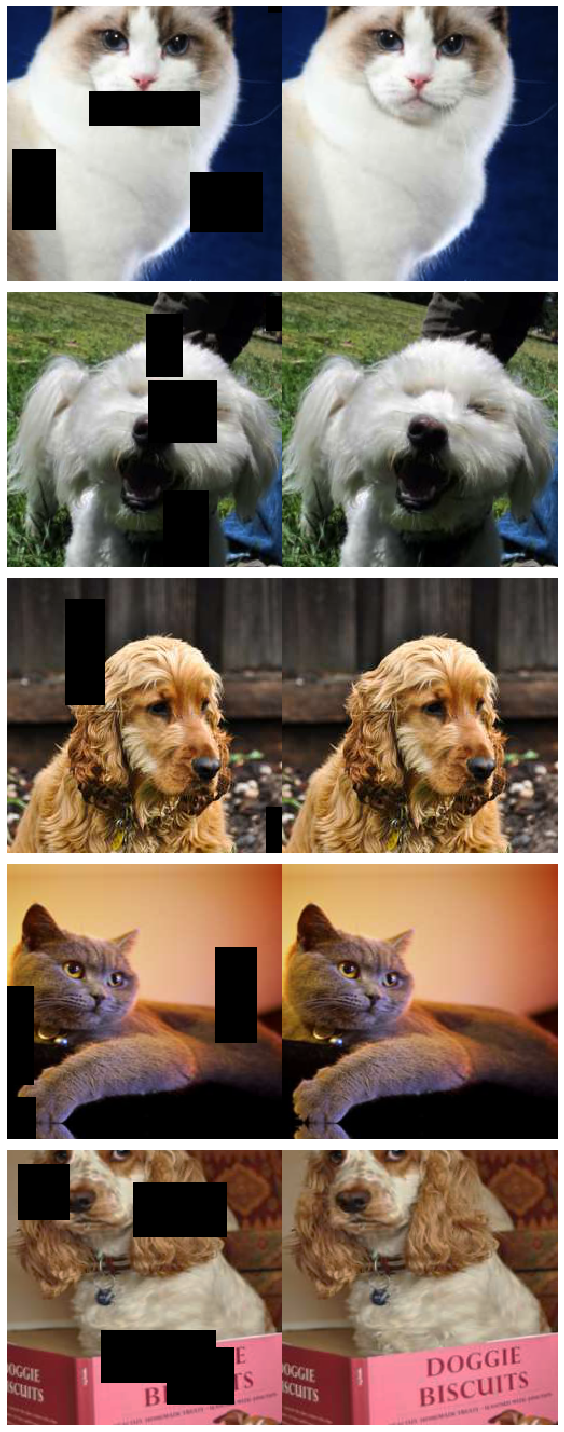

In [11]:
data.show_batch()

## Feature loss

In [12]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [13]:
base_loss = F.l1_loss

In [14]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layers, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layers))
              ] + [f'gram_{i}' for i in range(len(layers))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [15]:
res_m = resnet34(True).cuda().eval()
requires_grad(res_m, False)

In [16]:
layers = [res_m.layer2, res_m.layer3, res_m.layer4]
feat_loss = FeatureLoss(res_m, layers=layers, layer_wgts=[5, 15, 2])

## Train

In [17]:
learn = unet_learner(data, models.resnet34, wd=1e-3, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight).to_fp16()

In [18]:
learn.load('stage-2-128')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


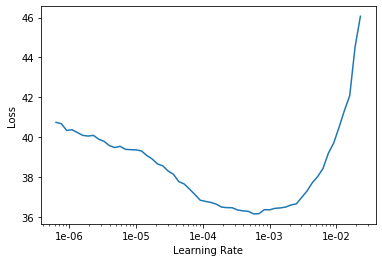

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 2e-5

In [ ]:
learn.freeze()
learn.fit_one_cycle(10, lr, pct_start=0.8)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,35.775028,33.595783,0.225141,0.331326,0.656722,0.682472,5.034924,13.764236,12.900963,03:05
1,31.111265,30.411079,0.210159,0.310123,0.598758,0.628342,4.492814,12.338950,11.831927,02:58
2,29.856243,29.481312,0.203725,0.301290,0.576468,0.610093,4.360016,11.803248,11.626470,02:58


In [ ]:
learn.save('stage-1-256')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


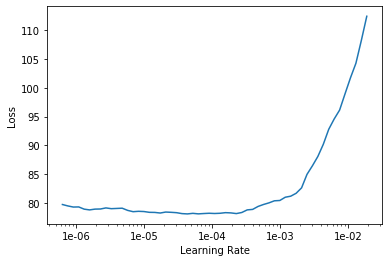

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5, lr/5), pct_start=0.9)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,78.740700,79.893616,0.204354,0.372281,0.686426,1.023759,8.058630,26.334238,43.213928,01:19
1,78.520287,77.628952,0.205959,0.375035,0.678248,0.996387,8.034546,25.787664,41.551117,00:59
2,78.588219,77.492149,0.202967,0.372924,0.673536,0.996396,7.964770,25.576859,41.704693,00:59
3,78.552917,77.178505,0.202586,0.369436,0.670397,0.987711,7.886150,25.683704,41.378513,00:59
4,78.004303,77.260803,0.206467,0.373881,0.678860,0.988864,7.993936,25.624977,41.393814,00:59
5,77.781212,77.066071,0.200364,0.368693,0.666696,0.987005,7.943305,25.415356,41.484665,01:00
6,78.023491,76.838661,0.202259,0.369330,0.670551,0.982890,8.015242,25.438932,41.159454,00:59
7,78.335655,78.482910,0.205483,0.373903,0.680703,1.003190,8.050402,26.032969,42.136257,00:59
8,78.171112,77.337639,0.204534,0.371112,0.675102,0.989061,8.016538,25.714336,41.366955,00:59
9,77.974380,76.508438,0.202301,0.367875,0.668681,0.977655,7.933651,25.569204,40.789066,01:00


In [24]:
learn.save('stage-2-128')

(None, None)

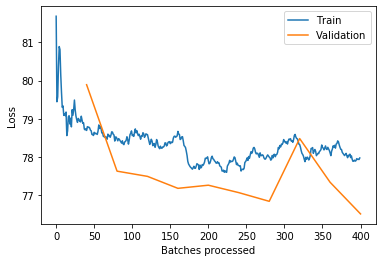

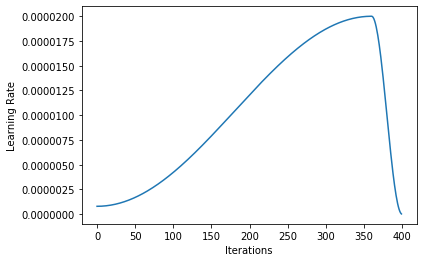

In [22]:
learn.recorder.plot_losses(), learn.recorder.plot_lr()

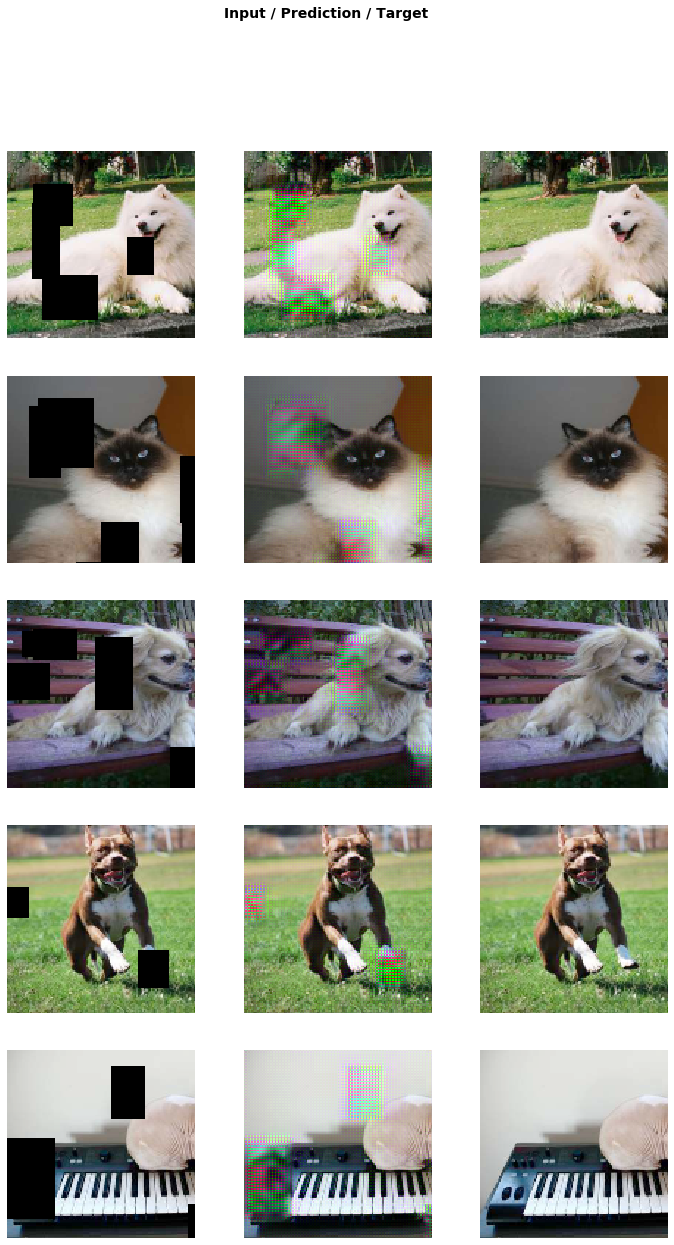

In [23]:
learn.show_results(ds_type=DatasetType.Valid)